Radek posted about this [here](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/discussion/309220), and linked to a GitHub repo with the code.

I just transferred that code here to Kaggle notebooks, that's all.

In [1]:
import numpy as np

def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.

    This function computes the average prescision at k between two lists of
    items.

    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The average precision at k over the input lists

    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.

    This function computes the mean average prescision at k between two lists
    of lists of items.

    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The mean average precision at k over the input lists

    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

# https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/discussion/308635
def customer_hex_id_to_int(series):
    return series.str[-16:].apply(hex_id_to_int)

def hex_id_to_int(str):
    return int(str[-16:], 16)

def article_id_str_to_int(series):
    return series.astype('int32')

def article_id_int_to_str(series):
    return '0' + series.astype('str')

class Categorize(BaseEstimator, TransformerMixin):
    def __init__(self, min_examples=0):
        self.min_examples = min_examples
        self.categories = []
        
    def fit(self, X):
        for i in range(X.shape[1]):
            vc = X.iloc[:, i].value_counts()
            self.categories.append(vc[vc > self.min_examples].index.tolist())
        return self

    def transform(self, X):
        data = {X.columns[i]: pd.Categorical(X.iloc[:, i], categories=self.categories[i]).codes for i in range(X.shape[1])}
        return pd.DataFrame(data=data)


def calculate_apk(list_of_preds, list_of_gts):
    # for fast validation this can be changed to operate on dicts of {'cust_id_int': [art_id_int, ...]}
    # using 'data/val_week_purchases_by_cust.pkl'
    apks = []
    for preds, gt in zip(list_of_preds, list_of_gts):
        apks.append(apk(gt, preds, k=12))
    return np.mean(apks)

def eval_sub(sub_csv, skip_cust_with_no_purchases=True):
    sub=pd.read_csv(sub_csv)
    validation_set=pd.read_parquet('data/validation_ground_truth.parquet')

    apks = []

    no_purchases_pattern = []
    for pred, gt in zip(sub.prediction.str.split(), validation_set.prediction.str.split()):
        if skip_cust_with_no_purchases and (gt == no_purchases_pattern): continue
        apks.append(apk(gt, pred, k=12))
    return np.mean(apks)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
%%time

transactions = pd.read_parquet('../input/warmup/transactions_train.parquet')
customers = pd.read_parquet('../input/parquet-new-assignement/new_customer_one.parquet')
articles = pd.read_parquet('../input/parquet-new-assignement/new_articles_one.parquet')

# sample = 0.05
# transactions = pd.read_parquet(f'data/transactions_train_sample_{sample}.parquet')
# customers = pd.read_parquet(f'data/customers_sample_{sample}.parquet')
# articles = pd.read_parquet(f'data/articles_train_sample_{sample}.parquet')

CPU times: user 3.17 s, sys: 1.81 s, total: 4.98 s
Wall time: 6.07 s


In [5]:
#adding of the column week to the dataframe transactions
transactions.t_dat = pd.to_datetime(transactions.t_dat, format='%Y-%m-%d')
transactions['week'] = 104 - (transactions.t_dat.max() - transactions.t_dat).dt.days // 7

In [6]:
#definition of the week for test
test_week = transactions.week.max() + 1 
#transactions = transactions[transactions.week > transactions.week.max() - 10]

# Generating candidates

### Last purchase candidates

In [7]:
#filtering only the weeks of the months of june/september 2020
filtered_transactions = transactions[(transactions['t_dat'].dt.month >= 6)
                                     & (transactions['t_dat'].dt.month <= 9)
                                     & (transactions['t_dat'].dt.year == 2020)]

#groupby of candidates based on the customer_id and extraction of weeks
c2weeks = filtered_transactions.groupby('customer_id')['week'].unique()

#creation of a dictionary for shifted weeks
c2weeks2shifted_weeks = {}
candidates_last_purchase_2020 = filtered_transactions.copy()

for c_id, weeks in c2weeks.items():
    c2weeks2shifted_weeks[c_id] = {}
    for i in range(weeks.shape[0]-1):
        c2weeks2shifted_weeks[c_id][weeks[i]] = weeks[i+1]
    c2weeks2shifted_weeks[c_id][weeks[-1]] = test_week

#update of the dataframe candidates_last_purchase_2020
weeks = []
for i, (c_id, week) in enumerate(zip(filtered_transactions['customer_id'], filtered_transactions['week'])):
    weeks.append(c2weeks2shifted_weeks[c_id][week])
    
candidates_last_purchase_2020.week = weeks

### candidates

In [8]:
#creation of the mean price of purchases for each candidate only in the filtered transactions
mean_price_purchases = filtered_transactions.groupby('customer_id')['price'].mean().rename('mean price purchases').reset_index()
mean_price_purchases

,customer_id,mean price purchases
0,28847241659200,0.036918
1,41318098387474,0.027525
2,77117344919861,0.020068
3,116809474287335,0.029644
4,200292573348128,0.031618
...,...,...
598997,18446624797007271432,0.013119
598998,18446630855572834764,0.061000
598999,18446662237889060501,0.033881
599000,18446705133201055310,0.050831


In [9]:
#identification of the gender group that is the most present in a specific geographic area
most_present_gender = customers.groupby(['customer_id', 'postal_code', 'numerical_gender']).size().reset_index(name='count')
idx = most_present_gender.groupby(['customer_id', 'postal_code'])['count'].transform(max) == most_present_gender['count']
most_present_gender = most_present_gender[idx][['customer_id', 'postal_code', 'numerical_gender']]
most_present_gender = most_present_gender.rename(columns = {'numerical_gender': 'most_present_gender_in_area'})
most_present_gender.drop(columns = 'postal_code', inplace = True)
most_present_gender

,customer_id,most_present_gender_in_area
0,4245900472157,2
1,23962613628581,0
2,25398598941468,2
3,28847241659200,2
4,41046458195168,2
...,...,...
1371975,18446630855572834764,0
1371976,18446662237889060501,2
1371977,18446705133201055310,0
1371978,18446723086055369602,2


In [10]:
#identification of the medium age for geographic area
median_age = customers.groupby(['customer_id', 'postal_code'])['age'].median().reset_index(name = 'median_age_area')
median_age.drop(columns = 'postal_code', inplace = True)
median_age

,customer_id,median_age_area
0,4245900472157,21.0
1,23962613628581,34.0
2,25398598941468,21.0
3,28847241659200,21.0
4,41046458195168,18.0
...,...,...
1371975,18446630855572834764,33.0
1371976,18446662237889060501,75.0
1371977,18446705133201055310,60.0
1371978,18446723086055369602,33.0


In [11]:
candidates_definitive = pd.merge(candidates_last_purchase_2020, mean_price_purchases, on = 'customer_id') #merge of values of mean fo the purchases
candidates_definitive = pd.merge(candidates_definitive, most_present_gender, on = 'customer_id') #merge of values of the dominant gender in teh geographic area of the customer
candidates_definitive = pd.merge(candidates_definitive, median_age, on = 'customer_id') #merge of values of the dominant gender in teh geographic area of the customer

candidates_definitive.columns

Index(['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id',
       'week', 'mean price purchases', 'most_present_gender_in_area',
       'median_age_area'],
      dtype='object')

In [12]:
candidates_definitive = candidates_definitive.drop_duplicates(subset = 'customer_id')

In [13]:
#dataset about candidates in the analyzed period
candidates_definitive.reset_index(drop = True, inplace = True)
candidates_definitive

,t_dat,customer_id,article_id,price,sales_channel_id,week,mean price purchases,most_present_gender_in_area,median_age_area
0,2020-06-01,3030245210403714,399256023,0.016932,1,91,0.016424,2,47.0
1,2020-06-01,3697956998694085,854883003,0.030492,2,105,0.020534,2,52.0
2,2020-06-01,4563203946496378,802459001,0.003373,1,99,0.027263,0,35.0
3,2020-06-01,4813676888825046,874916005,0.016932,1,105,0.016932,2,24.0
4,2020-06-01,6289628826503662,523404032,0.025407,2,105,0.036706,0,62.0
...,...,...,...,...,...,...,...,...,...
598997,2020-09-22,18409112236320621348,860833002,0.025407,2,105,0.029644,2,21.0
598998,2020-09-22,18417769707947924979,729860001,0.022017,2,105,0.019475,2,40.0
598999,2020-09-22,18418054986721795659,873279003,0.042356,2,105,0.042356,0,28.0
599000,2020-09-22,18421175435799911749,863583001,0.033881,2,105,0.033881,2,28.0


In [14]:
#test set about transactions
test_set_transactions = filtered_transactions.drop_duplicates('customer_id')
test_set_transactions.reset_index(drop = True, inplace = True)
test_set_transactions

,t_dat,customer_id,article_id,price,sales_channel_id,week
0,2020-06-01,3030245210403714,399256023,0.016932,1,88
1,2020-06-01,3697956998694085,854883003,0.030492,2,88
2,2020-06-01,4563203946496378,802459001,0.003373,1,88
3,2020-06-01,4813676888825046,874916005,0.016932,1,88
4,2020-06-01,6289628826503662,523404032,0.025407,2,88
...,...,...,...,...,...,...
598997,2020-09-22,18409112236320621348,860833002,0.025407,2,104
598998,2020-09-22,18417769707947924979,729860001,0.022017,2,104
598999,2020-09-22,18418054986721795659,873279003,0.042356,2,104
599000,2020-09-22,18421175435799911749,863583001,0.033881,2,104


In [15]:
#bestsellers for 2020
mean_price = filtered_transactions \
    .groupby(['week', 'article_id'])['price'].mean()

sales = filtered_transactions \
    .groupby('week')['article_id'].value_counts() \
    .groupby('week').rank(method='dense', ascending=False) \
    .groupby('week').head(50).rename('bestseller_rank').astype('int8')

bestsellers_2020 = pd.merge(sales, mean_price, on=['week', 'article_id']).reset_index()

# Combining transactions and candidates / negative examples

##### Images to create negative candidates

In [16]:
#print(bestsellers_2020[bestsellers_2020['bestseller_rank'] == 1]) #first bestseller for each considered week

In [17]:
top_5_bestsellers_article_ref = bestsellers_2020['article_id'][bestsellers_2020['bestseller_rank'].between(1, 5)]
top_5_bestsellers_article_ref = top_5_bestsellers_article_ref.reset_index(drop = True)
#top_5_bestsellers_article_ref = pd.DataFrame(top_5_bestsellers_article_ref)
top_5_bestsellers_article_ref

0     859105003
1     599580038
2     599580052
3     841434001
4     859105002
        ...    
80    924243001
81    924243002
82    918522001
83    923758001
84    866731001
Name: article_id, Length: 85, dtype: int64

In [18]:
top_5_bestsellers_article_ref = article_id_int_to_str(top_5_bestsellers_article_ref)
top_5_bestsellers_article_ref

0     0859105003
1     0599580038
2     0599580052
3     0841434001
4     0859105002
         ...    
80    0924243001
81    0924243002
82    0918522001
83    0923758001
84    0866731001
Name: article_id, Length: 85, dtype: object

In [19]:
import os 

directory = '../input/h-and-m-personalized-fashion-recommendations/images'
found_images_5bestsellers = []

for root, dirs, files in os.walk(directory):
    for file in files:
        article_id = file.split('.')[0].strip().lower()
        if article_id in [x.strip().lower() for x in top_5_bestsellers_article_ref]:
            found_images_5bestsellers.append(article_id)

In [20]:
bestsellers_2020_str = article_id_int_to_str(bestsellers_2020['article_id'])
bestsellers_2020_str

0      0859105003
1      0599580038
2      0599580052
3      0841434001
4      0859105002
          ...    
845    0911699002
846    0923340001
847    0904571001
848    0896169002
849    0881942001
Name: article_id, Length: 850, dtype: object

In [21]:
matching_article_ids_2020 = []

for root, dirs, files in os.walk(directory):
    for file in files:
        article_id = file.split('.')[0].strip().lower()
        if article_id in [x.strip().lower() for x in bestsellers_2020_str]:
            matching_article_ids_2020.append(article_id)

In [22]:
'''directory = '/kaggle/input/h-and-m-personalized-fashion-recommendations/images'

image_count = 0

for root, dirs, files in os.walk(directory):
    for file in files:
        # Check if the file is an image (you can customize the extension list)
        if file.lower().endswith(('.jpg')):
            image_count += 1

print(f"Total number of images in {directory} and its subdirectories: {image_count}")'''

'directory = \'/kaggle/input/h-and-m-personalized-fashion-recommendations/images\'\n\nimage_count = 0\n\nfor root, dirs, files in os.walk(directory):\n    for file in files:\n        # Check if the file is an image (you can customize the extension list)\n        if file.lower().endswith((\'.jpg\')):\n            image_count += 1\n\nprint(f"Total number of images in {directory} and its subdirectories: {image_count}")'

In [23]:
#unique elements of bestsellers_2020_str and top_5_bestsellers_article_ref
unique_article_count_bestsellers_2020 = len(set(bestsellers_2020_str))
unique_article_count_5_bestsellers = len(set(top_5_bestsellers_article_ref))

print(f"Total number of unique articles in bestsellers_2020_str: {unique_article_count_bestsellers_2020}")
print(f"Total number of unique articles in top_5_bestsellers_article_ref: {unique_article_count_5_bestsellers}")

Total number of unique articles in bestsellers_2020_str: 434
Total number of unique articles in top_5_bestsellers_article_ref: 60


In [24]:
#remove of duplicate elements from the arrays
found_images_5bestsellers = set(found_images_5bestsellers)
matching_article_ids_2020 = set(matching_article_ids_2020)

In [25]:
#function to find images in the image folder
def find_images(image_filename, base_folder='/kaggle/input/h-and-m-personalized-fashion-recommendations/images'):
    for root, dirs, files in os.walk(base_folder):
        if (image_filename + '.jpg') in files:
            return os.path.join(root, image_filename + '.jpg')
    return None

In [26]:
found_images = []

for image_filename in matching_article_ids_2020:
    image_path = find_images(image_filename)
    if image_path:
        found_images.append(image_path)

In [27]:
print(len(found_images))
print(len(matching_article_ids_2020))

431
431


In [28]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage import color, transform

#function to calculate the structural similarity index between images
def calculate_ssi(image1, image2):
    if image1.shape != image2.shape:
        image2 = transform.resize(image2, image1.shape, mode='reflect', anti_aliasing=True)
    gray1 = color.rgb2gray(image1)
    gray2 = color.rgb2gray(image2)
    return ssim(gray1, gray2)

reference_image_path = found_images[0]

reference_image = cv2.imread(reference_image_path)

similarity_scores = []

for image_path in found_images[1:]:
    current_image = cv2.imread(image_path)
    
    similarity_score = calculate_ssi(reference_image, current_image)
    
    similarity_scores.append((image_path, similarity_score))

In [29]:
#dataframe about the similarity scores
similarity = pd.DataFrame(similarity_scores, columns = ['path to image', 'similarity with item 929165002'])
similarity

,path to image,similarity with item 929165002
0,/kaggle/input/h-and-m-personalized-fashion-rec...,0.765768
1,/kaggle/input/h-and-m-personalized-fashion-rec...,0.708255
2,/kaggle/input/h-and-m-personalized-fashion-rec...,0.930020
3,/kaggle/input/h-and-m-personalized-fashion-rec...,0.786449
4,/kaggle/input/h-and-m-personalized-fashion-rec...,0.930863
...,...,...
425,/kaggle/input/h-and-m-personalized-fashion-rec...,0.725394
426,/kaggle/input/h-and-m-personalized-fashion-rec...,0.715877
427,/kaggle/input/h-and-m-personalized-fashion-rec...,0.729497
428,/kaggle/input/h-and-m-personalized-fashion-rec...,0.819073


In [30]:
similarity['image_number'] = similarity['path to image'].str.extract(r'/(\d+)\.jpg')
similarity

,path to image,similarity with item 929165002,image_number
0,/kaggle/input/h-and-m-personalized-fashion-rec...,0.765768,0766346003
1,/kaggle/input/h-and-m-personalized-fashion-rec...,0.708255,0921906003
2,/kaggle/input/h-and-m-personalized-fashion-rec...,0.930020,0806388010
3,/kaggle/input/h-and-m-personalized-fashion-rec...,0.786449,0880839001
4,/kaggle/input/h-and-m-personalized-fashion-rec...,0.930863,0399256005
...,...,...,...
425,/kaggle/input/h-and-m-personalized-fashion-rec...,0.725394,0895002002
426,/kaggle/input/h-and-m-personalized-fashion-rec...,0.715877,0879248001
427,/kaggle/input/h-and-m-personalized-fashion-rec...,0.729497,0914441007
428,/kaggle/input/h-and-m-personalized-fashion-rec...,0.819073,0547780003


In [31]:
type(similarity['image_number'][0])

str

In [32]:
#transformation of the column image_number into an int and deteletion of the zero 

def remove_zero_and_to_int(series):
    series_without_zeros = series.str.lstrip('0')
    return series_without_zeros.astype('int32')

similarity['image_number'] = remove_zero_and_to_int(similarity['image_number'])

In [33]:
similarity['image_number']

0      766346003
1      921906003
2      806388010
3      880839001
4      399256005
         ...    
425    895002002
426    879248001
427    914441007
428    547780003
429    870970001
Name: image_number, Length: 430, dtype: int32

##### Creation of the dataset to use

In [34]:
filtered_transactions.loc[:, 'purchased'] = 1

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [35]:
data = pd.concat([filtered_transactions, candidates_last_purchase_2020])
data = pd.merge(data, bestsellers_2020[['article_id', 'bestseller_rank']], on = 'article_id', how = 'left')
data = pd.merge(data, similarity[['image_number', 'similarity with item 929165002']], left_on = 'article_id', right_on = 'image_number', how = 'left')
data.fillna(0, inplace = True)

In [36]:
#adding candidates info
data = pd.merge(data, candidates_definitive[['customer_id', 'mean price purchases', 'most_present_gender_in_area', 'median_age_area']], on = 'customer_id', how = 'left')

In [37]:
#adding initial datasets to my new dataset
data = pd.merge(data, articles, on = 'article_id', how = 'left')
data = pd.merge(data, customers, on = 'customer_id', how = 'left')

In [38]:
data.sort_values(['week', 'customer_id'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [39]:
train = data[data.week != test_week]
test = data[data.week==test_week].drop_duplicates(['customer_id', 'article_id', 'sales_channel_id']).copy()

In [40]:
train_baskets = train.groupby(['week', 'customer_id'])['article_id'].count().values

In [41]:
columns_to_use = ['article_id', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id',
'perceived_colour_master_id', 'department_no', 'index_code', 'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active',
'club_member_status', 'fashion_news_frequency', 'bestseller_rank', 'mean price purchases', 'most_present_gender_in_area', 'median_age_area',
'numerical_gender', 'numerical_article_gender', 'similarity with item 929165002']

In [42]:
%%time

train_X = train[columns_to_use]
train_y = train['purchased']

test_X = test[columns_to_use]

CPU times: user 234 ms, sys: 167 ms, total: 401 ms
Wall time: 400 ms


# Model training

In [43]:
from lightgbm.sklearn import LGBMRanker

In [44]:
ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1,
    importance_type='gain',
    verbose=10
)

In [45]:
%%time

ranker = ranker.fit(
    train_X,
    train_y,
    group = train_baskets,
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.786548
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.201759
[LightGBM] [Debug] init for col-wise cost 0.251642 seconds, init for row-wise cost 1.912674 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.821353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1384
[LightGBM] [Info] Number of data points in the train set: 10264565, number of used features: 22
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
CPU times: user 28.2 s, sys: 1.32 s, total: 29.6 s
Wall time: 9.75 s


In [46]:
for i in ranker.feature_importances_.argsort()[::-1]:
    print(columns_to_use[i], ranker.feature_importances_[i]/ranker.feature_importances_.sum())

article_id 0.39634584470166895
bestseller_rank 0.2829809750715128
product_type_no 0.10079214956776665
department_no 0.08913656047808187
section_no 0.03509984268867263
garment_group_no 0.034778985825386625
perceived_colour_master_id 0.016714483179840506
graphical_appearance_no 0.015614528310100352
similarity with item 929165002 0.015199392607633542
index_group_no 0.013337237569336044
mean price purchases 0.0
fashion_news_frequency 0.0
club_member_status 0.0
Active 0.0
FN 0.0
numerical_article_gender 0.0
most_present_gender_in_area 0.0
index_code 0.0
median_age_area 0.0
perceived_colour_value_id 0.0
colour_group_code 0.0
numerical_gender 0.0


# Calculate predictions

In [47]:
%time

test['preds'] = ranker.predict(test_X)

c_id2predicted_article_ids = test \
    .sort_values(['customer_id', 'preds'], ascending=False) \
    .groupby('customer_id')['article_id'].apply(list).to_dict()

bestsellers_2020_all = \
    bestsellers_2020[bestsellers_2020.week == bestsellers_2020.week.max()]['article_id'].tolist()

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs


# Create submission

In [48]:
sub = pd.read_csv('/kaggle/input/h-and-m-personalized-fashion-recommendations/sample_submission.csv')

In [49]:
%%time
preds = []
for c_id in customer_hex_id_to_int(sub.customer_id):
    pred = c_id2predicted_article_ids.get(c_id, [])
    pred = pred + bestsellers_2020_all
    preds.append(pred[:50])

CPU times: user 7.58 s, sys: 431 ms, total: 8.01 s
Wall time: 8.01 s


In [50]:
preds = [' '.join(['0' + str(p) for p in ps]) for ps in preds]
sub.prediction = preds

In [51]:
sub_name = 'submission'
sub.to_csv(f'{sub_name}.csv', index=False)

# Evaluation of the model V1

In [52]:
test.columns

Index(['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id',
       'week', 'purchased', 'bestseller_rank', 'image_number',
       'similarity with item 929165002', 'mean price purchases',
       'most_present_gender_in_area', 'median_age_area', 'product_code',
       'prod_name', 'product_type_no', 'product_type_name',
       'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc',
       'numerical_article_gender', 'FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 'postal_code', 'numerical_gender',
       'preds'],
      dtype='object'

In [53]:
clothes_purchased = []
filtered_transactions = filtered_transactions.reset_index(drop = True)

for index, purchase in enumerate(filtered_transactions['purchased']):
    if purchase == 1:
        clothes_purchased.append(filtered_transactions.at[index, 'article_id'])

In [54]:
#value of k to calculate precision, recall
k_value = [10, 20, 50, 100]

In [55]:
#precision at K 
def precision_at_k(clothes_purchased, preds, k):
    predicted_at_k = preds[:k]
    relevant_at_k = clothes_purchased and predicted_at_k
    precision = len(relevant_at_k) / k
    return precision


#precision = precision_at_k(clothes_purchased, preds, k_value)
#print(f'Precision at {k_value}: {precision}')

In [56]:
#recall at k
def recall_at_k(clothes_purchased, preds, k):
    predicted_at_k = preds[:k]
    relevant_at_k = clothes_purchased and predicted_at_k
    recall_at_k = len(relevant_at_k) / len(clothes_purchased)
    return recall_at_k

#recall = recall_at_k(clothes_purchased, preds, k_value)
#print(f'Recall at {k_value}: {recall}')

In [57]:
precisions = []
recalls = []

for k in k_value:
    precision = precision_at_k(clothes_purchased, preds, k)
    recall = recall_at_k(clothes_purchased, preds, k)
    precisions.append(precision)
    recalls.append(recall)
    print(f'Precision at {k}: {precision:.4f}, Recall at {k}: {recall:.10f}')

Precision at 10: 1.0000, Recall at 10: 0.0000019412
Precision at 20: 1.0000, Recall at 20: 0.0000038824
Precision at 50: 1.0000, Recall at 50: 0.0000097060
Precision at 100: 1.0000, Recall at 100: 0.0000194119


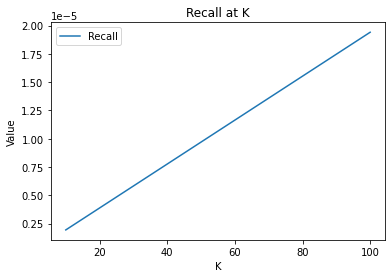

In [58]:
#graph about recall

plt.plot(k_value, recalls, label = 'Recall')
plt.xlabel('K')
plt.ylabel('Value')
plt.title('Recall at K')
plt.legend()
plt.show()

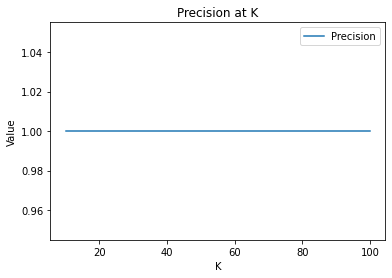

In [59]:
#graph about precision

plt.plot(k_value, precisions, label = 'Precision')
plt.xlabel('K')
plt.ylabel('Value')
plt.title('Precision at K')
plt.legend()
plt.show()

# Evaluation of the model V2

In [60]:
!pip install recmetrics

     |████████████████████████████████| 24.8 MB 33.1 MB/s            
     |████████████████████████████████| 13.2 MB 54.8 MB/s            
     |████████████████████████████████| 225 kB 55.6 MB/s            
     |████████████████████████████████| 54 kB 2.4 MB/s             
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.1
    Uninstalling scikit-learn-1.0.1:
      Successfully uninstalled scikit-learn-1.0.1
  Attempting uninstall: plotly
    Found existing installation: plotly 5.6.0
    Uninstalling plotly-5.6.0:
      Successfully uninstalled plotly-5.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.5.1 which is incompatible.
featuretools 1.6.0 requires numpy>=1.21.0, but you have numpy 1.20.3 which is incompatible.


In [61]:
#reference: https://github.com/statisticianinstilettos/recmetrics

from recmetrics import metrics

#precision
recommender_precision = metrics.recommender_precision(predicted = preds, actual = test_X)
print('Value of precision:', recommender_precision)

#recall
recommender_recall = metrics.recommender_recall(predicted = preds, actual = test_X)
print('Value of recall:', recommender_recall)

#MAP --> not working: isn't finding the function
#recommender_mapk = metrics.mapk(predicted = preds, actual = test_X, k = 10)
#print('Value of MAP@K:', recommender_mapk)

#MARK
reccomender_mark = metrics.mark(predicted = preds, actual = test_X, k = 100)
print('Value of MAR@K:', reccomender_mark)

#personalization --> reccomendation similarity across users: high = personalization are different and good; low = personalization are similar and not good
personalization_score = metrics.personalization(predicted = preds[:20000])
print('Value of personalization:', personalization_score)

Value of precision: 0.03924545454545455
Value of recall: 0.7553045454545455
Value of MAR@K: 0.005882892721749391
Value of personalization: 0.6912054102705135
